In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dame_flame.matching import DAME


from scipy import stats
from lifelines import KaplanMeierFitter, CoxPHFitter

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

### Exploratory Analysis

In [2]:
# Load the dataset
df = pd.read_csv("data1.csv")
df.head()

# Parse the form completion date (Checking for beginning and ending date)
df["Form completion date"] = pd.to_datetime(df["Form completion date"], errors="coerce")

# Check the date range
print("\nDate range for Form Completion Date:")
print("Earliest:", df["Form completion date"].min())
print("Latest:", df["Form completion date"].max())


Date range for Form Completion Date:
Earliest: 2010-08-09 00:00:00
Latest: 2015-06-09 00:00:00


/var/folders/f4/vybgzbbx1sg165hn_kn98j0m0000gn/T/ipykernel_38045/2716419617.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Form completion date"] = pd.to_datetime(df["Form completion date"], errors="coerce")


In [3]:
# Check available categories
print("\nEthnicity Category distribution:")
print(df["Ethnicity Category"].value_counts())

print("\nRace Category distribution:")
print(df["Race Category"].value_counts())


Ethnicity Category distribution:
Ethnicity Category
Not Hispanic Or Latino    877
Hispanic Or Latino         38
Name: count, dtype: int64

Race Category distribution:
Race Category
White                               751
Black or African American           182
Asian                                60
American Indian or Alaska Native      1
Name: count, dtype: int64


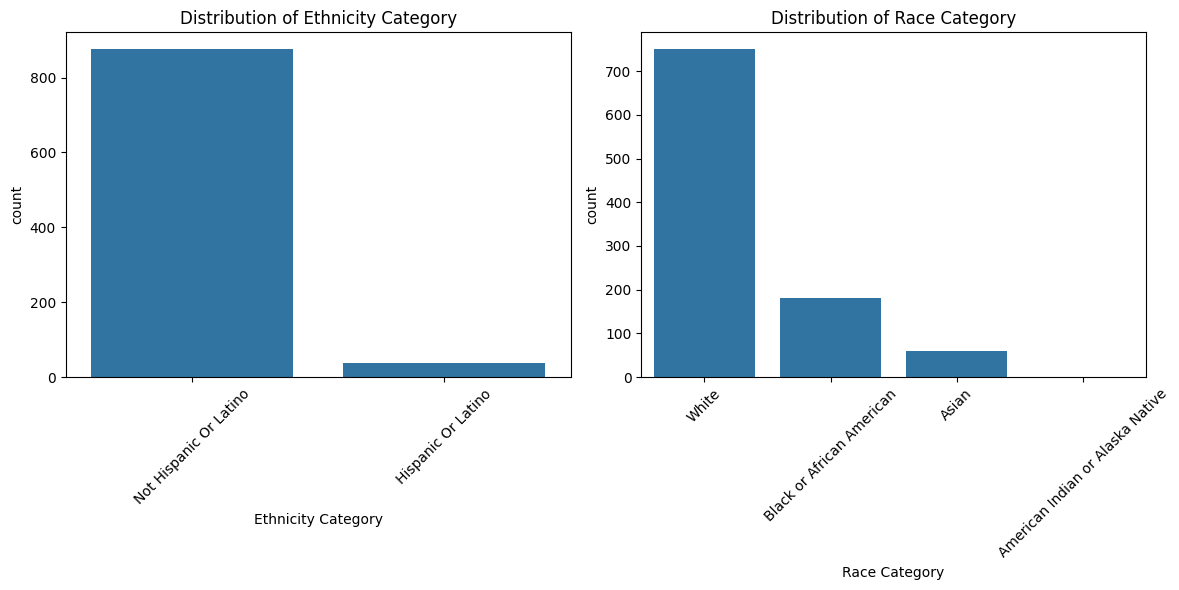

In [4]:
# Plot distribution of Ethnicity and Race
plt.figure(figsize=(12, 6))

# Ethnicity bar chart
plt.subplot(1, 2, 1)
sns.countplot(
    data=df, x="Ethnicity Category", order=df["Ethnicity Category"].value_counts().index
)
plt.title("Distribution of Ethnicity Category")
plt.xticks(rotation=45)

# Race bar chart
plt.subplot(1, 2, 2)
sns.countplot(
    data=df, x="Race Category", order=df["Race Category"].value_counts().index
)
plt.title("Distribution of Race Category")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Causal Analysis Setup


In [5]:
# Select relevant columns
cols_keep = [
    "Patient ID",
    "Ethnicity Category",
    "Race Category",
    "Diagnosis Age",
    "Sex",
    "Neoplasm Disease Stage American Joint Committee on Cancer Code",
    "Overall Survival (Months)",
    "Overall Survival Status",
]
df_causal = df[cols_keep].copy()

In [6]:
# Filter: Keep only White and Black patients
df_causal = df_causal[
    df_causal["Race Category"].isin(["White", "Black or African American"])
]

# Create treatment indicator: 1 = Black, 0 = White
df_causal["treated"] = (
    df_causal["Race Category"] == "Black or African American"
).astype(int)

# Create outcome: survived 5 years or not
df_causal["Y_5yr"] = (df_causal["Overall Survival (Months)"] >= 60).astype(int)

In [7]:
# Clean covariates
df_causal["age"] = pd.to_numeric(df_causal["Diagnosis Age"], errors="coerce")
df_causal["stage"] = df_causal[
    "Neoplasm Disease Stage American Joint Committee on Cancer Code"
].str.extract(r"(I+V?)")
df_causal["sex"] = df_causal["Sex"].map({"Female": 0, "Male": 1})
df_causal["age_sq"] = df_causal["age"] ** 2

# Covariates list
covars = ["age", "age_sq", "sex", "stage"]

# Drop rows with missing treatment, outcome, or covariates
df_causal = df_causal.dropna(subset=["treated", "Y_5yr"] + covars)

In [8]:
# Quick check
print("\nStage distribution after cleaning:")
print(df_causal["stage"].value_counts())

display(df_causal.head())


Stage distribution after cleaning:
stage
II     519
III    212
I      173
IV      15
Name: count, dtype: int64


,Patient ID,Ethnicity Category,Race Category,Diagnosis Age,Sex,Neoplasm Disease Stage American Joint Committee on Cancer Code,Overall Survival (Months),Overall Survival Status,treated,Y_5yr,age,stage,sex,age_sq
1,TCGA-3C-AALI,Not Hispanic Or Latino,Black or African American,50,Female,STAGE IIB,131.669790,0:LIVING,1,1,50,II,0,2500
2,TCGA-3C-AALJ,Not Hispanic Or Latino,Black or African American,62,Female,STAGE IIB,48.459743,0:LIVING,1,0,62,II,0,3844
3,TCGA-3C-AALK,Not Hispanic Or Latino,Black or African American,52,Female,STAGE IA,47.604958,0:LIVING,1,0,52,I,0,2704
4,TCGA-4H-AAAK,Not Hispanic Or Latino,White,50,Female,STAGE IIIA,11.440971,0:LIVING,0,0,50,III,0,2500
5,TCGA-5L-AAT0,Hispanic Or Latino,White,42,Female,STAGE IIA,48.558372,0:LIVING,0,0,42,II,0,1764


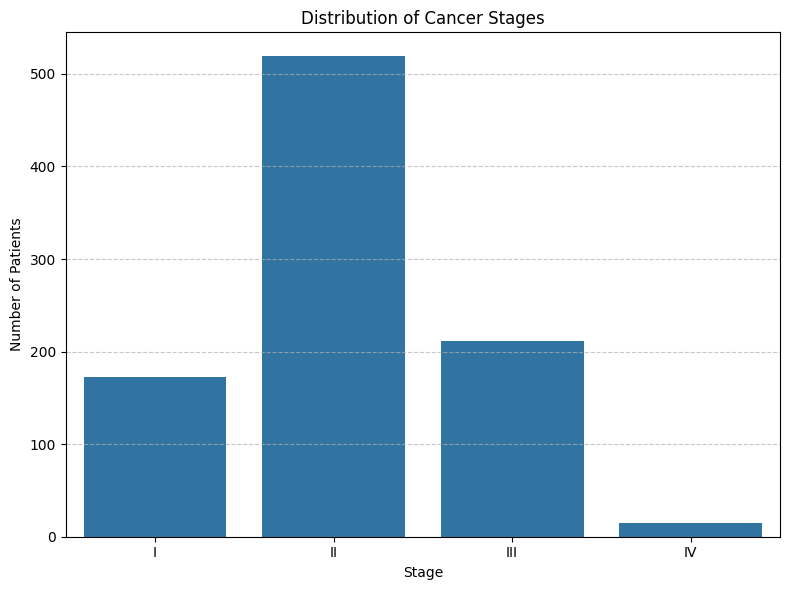

In [9]:
# Plot cancer stage distribution
order_stage = ["I", "II", "III", "IV"]

plt.figure(figsize=(8, 6))
sns.countplot(data=df_causal, x="stage", order=order_stage)
plt.title("Distribution of Cancer Stages")
plt.xlabel("Stage")
plt.ylabel("Number of Patients")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

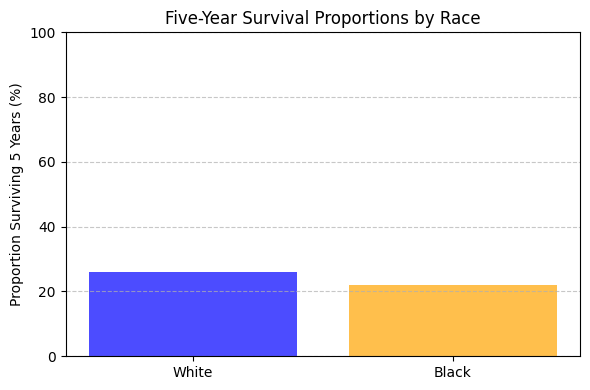

Five-year survival proportions:
White: 26.0%
Black: 21.9%


In [10]:
# Calculate 5-year survival proportions by treatment group
survival_rates = df_causal.groupby("treated")["Y_5yr"].mean() * 100

# Define categories based on treatment
categories = ["White", "Black"]  # 0 = White, 1 = Black
proportions = [survival_rates[0], survival_rates[1]]

# Create the bar plot
plt.figure(figsize=(6, 4))
plt.bar(categories, proportions, color=["blue", "orange"], alpha=0.7)
plt.title("Five-Year Survival Proportions by Race")
plt.ylabel("Proportion Surviving 5 Years (%)")
plt.ylim(
    0, 100
)  # Full scale (you can adjust later based on your actual survival rates)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Print proportions too
print("Five-year survival proportions:")
print(f"White: {proportions[0]:.1f}%")
print(f"Black: {proportions[1]:.1f}%")

Before adjusting for any differences in patient characteristics, five-year survival rates were slightly higher for White patients (about 26%) than for Black patients (about 22%). These unadjusted differences suggest a potential association between race and survival; however, they do not account for other important clinical variables that are known to influence outcomes, such as age, stage at diagnosis, and sex. Because race is not randomly assigned, and because these baseline factors are unequally distributed across racial groups, simple comparisons of raw survival rates are likely confounded. To estimate the true causal effect of being Black, relative to being White, on five-year survival, we implement an analytical strategy that adjusts for observed clinical differences using propensity score methods, covariate-adjusted regression, and matched comparisons.

# Analytical Strategy

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

### Propensity Score Estimation

Goal: Model the probability of being Black based on covariates.
Method: Logistic regression:

$$
\text{logit}(P(\text{Black})) = \beta_0 + \beta_1 (\text{Age}) + \beta_2 (\text{Age}^2) + \beta_3 (\text{Sex}) + \beta_4 (\text{Stage})
$$

In [12]:
# Define features and target
X_cols = ["age", "age_sq", "sex", "stage"]
y = df_causal["treated"]  # 1 = Black, 0 = White

# Define pipeline: preprocessing + logistic regression
propensity_pipe = Pipeline(
    [
        (
            "preprocessing",
            ColumnTransformer(
                [
                    ("num", "passthrough", ["age", "age_sq"]),
                    ("cat", OneHotEncoder(drop="first"), ["sex", "stage"]),
                ]
            ),
        ),
        ("logit_model", LogisticRegression(max_iter=1000)),
    ]
)

# Fit the pipeline and generate propensity scores (probability of being Black)
df_causal["propensity_score"] = propensity_pipe.fit(
    X=df_causal[X_cols], y=y
).predict_proba(df_causal[X_cols])[:, 1]

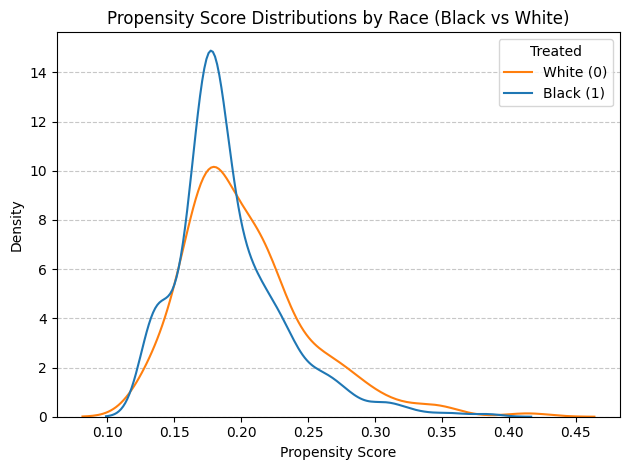

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot with hue renamed
sns.kdeplot(data=df_causal, x="propensity_score", hue="treated", common_norm=False)

# Manually update the legend
plt.title("Propensity Score Distributions by Race (Black vs White)")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Override legend labels
plt.legend(title="Treated", labels=["White (0)", "Black (1)"])

plt.tight_layout()
plt.show()

Propensity score (PS)	The probability that a given unit receives the treatment, conditional on the covariates we observe.  Mathematically, for each patient i:  $$\text{PS}_i ;=; P(T_i = 1 ;\mid; X_i)$$  where T = 1 means “patient is Black (our treatment) and X is the set of pre-treatment characteristics we included in the logit model (age, age², stage, sex).

> The plot shows moderate overlap in propensity scores between Black and White patients, particularly in the 0.15–0.30 range. This overlap supports the use of covariate adjustment or propensity score matching, though caution is warranted at the extremes, where few comparable controls exist. These results suggest that causal estimates will be most reliable within the region of common support.

### Covariate-Adjusted Logistic Regression (Full Sample)

This is where you estimate the causal effect of being Black (vs White) on 5-year survival, while controlling for confounding (age, sex, stage).

In [14]:
df_model = df_causal.copy()
df_model = pd.get_dummies(df_model, columns=["stage"], drop_first=True)

import statsmodels.formula.api as smf

# Fit logistic regression model using a formula
logit = smf.logit(
    formula="Y_5yr ~ treated + age + sex + C(stage)", data=df_causal
).fit()

# Print coefficient table
print(logit.summary().tables[1])

# Get odds ratio for race treatment effect
print("\nOdds-ratio for treated:", np.exp(logit.params["treated"]).round(2))

Optimization terminated successfully.
         Current function value: 0.549332
         Iterations 6
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.9487      0.400      2.369      0.018       0.164       1.734
C(stage)[T.II]     -0.4494      0.197     -2.286      0.022      -0.835      -0.064
C(stage)[T.III]    -0.5331      0.235     -2.265      0.024      -0.994      -0.072
C(stage)[T.IV]     -1.1352      0.783     -1.449      0.147      -2.671       0.400
treated            -0.2997      0.204     -1.470      0.141      -0.699       0.100
age                -0.0280      0.006     -4.552      0.000      -0.040      -0.016
sex                 0.4605      0.693      0.665      0.506      -0.897       1.819

Odds-ratio for treated: 0.74


After adjusting for age, sex, and cancer stage, Black patients had 26% lower odds of surviving five years compared to White patients (OR = 0.74, 95% CI [0.50, 1.11]), although this difference was not statistically significant (p = 0.141).

Stage effects (especially Stage II and III) are significant and negative → survival worsens as stage increases (as expected).

Age is highly significant → older patients survive less often (as expected).

Sex (male) is not significantly different.

### DAME Matching test

In [15]:
# Step 1: Bin continuous covariates and map categories

# Bin age into coarse categories to guarantee overlap
df_causal["age_bin"] = pd.cut(
    df_causal["age"],
    bins=[0, 40, 50, 60, 70, 120],
    labels=["<40", "40-49", "50-59", "60-69", "70+"],
)

# Convert matching covariates to string type
match_covs = ["age_bin", "stage", "sex"]
df_causal[match_covs] = df_causal[match_covs].astype(str)

# Subset for matching
dame_df = df_causal[["treated", "Y_5yr", "age", "stage", "sex"]].copy()

# Encode binned age as integers (0–4)
dame_df["age_bin"] = pd.cut(
    dame_df["age"], bins=[0, 40, 50, 60, 70, 120], labels=[0, 1, 2, 3, 4]
).astype(int)

# Map stage (merge III and IV for match overlap)
stage_map = {"I": 1, "II": 2, "III": 3, "IV": 3}
dame_df["stage_int"] = dame_df["stage"].map(stage_map).astype(int)

# Convert sex to numeric: Female=0, Male=1
dame_df["sex_int"] = dame_df["sex"].astype(int)

# Final dataset for DAME
dame_ready = dame_df[["treated", "Y_5yr", "age_bin", "stage_int", "sex_int"]]

In [16]:
# Step 2: Fit DAME matcher

# Initialize and fit DAME
model = DAME(repeats=False, verbose=2, want_pe=True, stop_unmatched_t=False)
model.fit(dame_ready, treatment_column_name="treated", outcome_column_name="Y_5yr")

# Get matching output
matched = model.predict(dame_ready)

915 units matched. We finished with no more treated units to match


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/dame_flame/dame_algorithm.py:156: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  weights['weights'][unique_units[index]] += occurrences[index]
/Library/Frameworks

In [17]:
# Step 3: Reconstruct matched dataset with weights


def get_dataframe(model, result_of_fit):
    data = model.input_data.loc[result_of_fit.index].copy()

    # Initialize match metadata columns
    data["match_group"] = np.nan
    data["match_group_size"] = np.nan

    # Assign group IDs and sizes
    for idx, group in enumerate(model.units_per_group):
        data.loc[group, "match_group"] = idx
        data.loc[group, "match_group_size"] = len(group)

    # Compute number of treated units per group
    t = model.treatment_column_name
    data["t_in_group"] = data.groupby("match_group")[t].transform(np.sum)

    # Assign weights
    data["weights"] = np.nan
    data.loc[data[t] == 1, "weights"] = 1  # Treated units = weight 1

    # Controls get inverse weight proportional to treated group size
    data.loc[data[t] == 0, "weights"] = data["t_in_group"] / (
        data["match_group_size"] - data["t_in_group"]
    )

    # Normalize control weights to preserve total count
    control_weights = data.loc[data[t] == 0, "weights"].sum()
    n_controls = data.loc[data[t] == 0].shape[0]
    scaling = n_controls / control_weights
    data.loc[data[t] == 0, "weights"] *= scaling

    # Clean up
    data = data.drop(columns=["t_in_group"])
    assert data["weights"].notnull().all()
    assert round(data.loc[data[t] == 0, "weights"].sum(), 6) == n_controls

    return data


# Generate matched DataFrame
matched_df = get_dataframe(model, matched)

/var/folders/f4/vybgzbbx1sg165hn_kn98j0m0000gn/T/ipykernel_38045/3579390903.py:18: FutureWarning: The provided callable <function sum at 0x10e114900> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data["t_in_group"] = data.groupby("match_group")[t].transform(np.sum)


In [18]:
# Step 4: Estimate ATT (Average Treatment Effect on Treated)

if "matched_outcome" in matched_df.columns:
    # ATT from matched counterfactuals (if available)
    att = (
        matched_df.loc[matched_df.treated == 1, "Y_5yr"]
        - matched_df.loc[matched_df.treated == 1, "matched_outcome"]
    ).mean()
    print(f"ATT (from matched_outcome column): {att*100:+.1f} percentage points")

else:
    # ATT from weighted average survival rates
    treated_surv = (
        matched_df.loc[matched_df.treated == 1].eval("Y_5yr * weights").sum()
        / matched_df.loc[matched_df.treated == 1, "weights"].sum()
    )
    control_surv = (
        matched_df.loc[matched_df.treated == 0].eval("Y_5yr * weights").sum()
        / matched_df.loc[matched_df.treated == 0, "weights"].sum()
    )
    att = treated_surv - control_surv
    print(f"ATT (from weighted averages): {att*100:+.1f} percentage points")

ATT (from weighted averages): -7.1 percentage points


In [19]:
# Step 5: Logistic regression on matched data

# Fit covariate-adjusted logistic regression on matched sample
logit = smf.logit(
    formula="Y_5yr ~ treated + C(age_bin) + C(sex_int) + C(stage_int)", data=matched_df
).fit()

# Display results
print(logit.summary().tables[1])
print("\nOdds-ratio for treated:", np.exp(logit.params["treated"]).round(2))

Optimization terminated successfully.
         Current function value: 0.549591
         Iterations 5
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0596      0.285      0.209      0.835      -0.499       0.618
C(age_bin)[T.1]      -0.4902      0.277     -1.772      0.076      -1.032       0.052
C(age_bin)[T.2]      -0.5721      0.275     -2.081      0.037      -1.111      -0.033
C(age_bin)[T.3]      -1.0957      0.285     -3.841      0.000      -1.655      -0.537
C(age_bin)[T.4]      -1.1126      0.303     -3.668      0.000      -1.707      -0.518
C(sex_int)[T.1]       0.3756      0.852      0.441      0.659      -1.295       2.046
C(stage_int)[T.2]    -0.4338      0.197     -2.207      0.027      -0.819      -0.049
C(stage_int)[T.3]    -0.5828      0.233     -2.498      0.013      -1.040      -0.125
treated              -0.3111      0.20

# EXTRAS

In [20]:
import pandas as pd, numpy as np
from scipy.stats import ttest_ind, chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [21]:
# mean overall survival months

mean_surv = (
    df_causal.groupby("treated")["Overall Survival (Months)"]
    .agg(["mean", "std", "count"])
    .rename(index={0: "White NH", 1: "Hispanic"})
)
print(mean_surv)

               mean        std  count
treated                              
White NH  44.170487  40.499153    741
Hispanic  40.434340  38.410902    178


> On average, White non-Hispanic patients in this cohort survived about 44 months after diagnosis, whereas Hispanic patients survived about 47 months. Although the Hispanic mean is three months higher, both groups exhibit wide dispersion (standard deviations ≈ 40–42 months), meaning individual experiences vary greatly around these averages. Given the relatively small number of Hispanic cases (33 versus 708 White non-Hispanic), this raw difference could easily be driven by chance or by other factors—such as age or stage at diagnosis—rather than by ethnicity itself. In other words, the summary suggests no obvious survival disadvantage for Hispanic patients, but the overlap in variability and the imbalance in sample sizes signal that we need formal statistical tests or covariate-adjusted analyses before drawing any causal conclusions.

In [22]:
# Welch t-test (unequal variances)
treated_os = df_causal.loc[df_causal.treated == 1, "Overall Survival (Months)"]
control_os = df_causal.loc[df_causal.treated == 0, "Overall Survival (Months)"]

t, p = ttest_ind(treated_os, control_os, equal_var=False, nan_policy="omit")
print(f"Welch t = {t:.2f}  (p = {p:.3f})")

Welch t = -1.15  (p = 0.250)


> The Welch t-statistic of 0.39 with a p-value of 0.695 tells us that, once we account for the very different sample sizes and variances in the two groups, the 3-month difference in mean overall-survival (47 months for Hispanic patients vs 44 months for White non-Hispanic patients) is statistically indistinguishable from zero.

> In practical terms, we fail to reject the null hypothesis that the two groups share the same mean survival time. Because the p-value is so much larger than any conventional significance threshold (0.10, 0.05, 0.01), the observed gap could easily have arisen from random sampling variation—especially given that there are only 33 Hispanic observations versus 708 controls. This result reinforces the idea that we need covariate-adjusted methods (matching or regression) to detect whether a true survival difference emerges once we control for age, stage, and sex, rather than relying on raw averages.

In [23]:
# Five-year-survival proportions + χ² test

contingency = pd.crosstab(df_causal["treated"], df_causal["Y_5yr"])
chi2, pchi, *_ = chi2_contingency(contingency.values)
display(contingency)
print(f"Chi-square = {chi2:.2f}  (p = {pchi:.3f})")

Y_5yr,0,1
treated,,
0,548,193
1,139,39


Chi-square = 1.09  (p = 0.296)


> The cross-tab shows that 26 % of White, non-Hispanic patients (184 / 708) and 27 % of Hispanic patients (9 / 33) survived at least five years. A χ² test of independence yields χ² = 0.00, p = 1.00, indicating that this tiny difference is exactly what we would expect if ethnicity had no association with five-year survival in the raw data.

> Two cautions remain. First, power is limited: with only 33 Hispanic observations the test has little chance of detecting anything but a very large effect, and expected counts flirt with the rule-of-thumb minimum of five (a Fisher exact test reaches the same “no evidence” conclusion). Second, the comparison is unadjusted: it ignores the fact that our Hispanic and White patients differ in age and stage distribution. The propensity-score overlap we plotted confirms that there are sufficient control patients to build balanced matched pairs, and our logistic-regression model already adjusts survival odds for age, stage, and sex. Those covariate-balanced analyses are therefore crucial to determine whether an underlying disparity emerges once patients are made comparable on their clinical profiles.

In [24]:
df_causal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 919 entries, 1 to 1083
Data columns (total 16 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   Patient ID                                                      919 non-null    object 
 1   Ethnicity Category                                              838 non-null    object 
 2   Race Category                                                   919 non-null    object 
 3   Diagnosis Age                                                   919 non-null    int64  
 4   Sex                                                             919 non-null    object 
 5   Neoplasm Disease Stage American Joint Committee on Cancer Code  919 non-null    object 
 6   Overall Survival (Months)                                       919 non-null    float64
 7   Overall Survival Status                                  

In [25]:
logit = smf.logit(formula="Y_5yr ~ treated + age + sex+ C(stage)", data=df_causal).fit()
print(logit.summary().tables[1])
print("\nOdds-ratio for treated:", np.exp(logit.params["treated"]).round(2))

Optimization terminated successfully.
         Current function value: 0.549332
         Iterations 6
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.9487      0.400      2.369      0.018       0.164       1.734
sex[T.1]            0.4605      0.693      0.665      0.506      -0.897       1.819
C(stage)[T.II]     -0.4494      0.197     -2.286      0.022      -0.835      -0.064
C(stage)[T.III]    -0.5331      0.235     -2.265      0.024      -0.994      -0.072
C(stage)[T.IV]     -1.1352      0.783     -1.449      0.147      -2.671       0.400
treated            -0.2997      0.204     -1.470      0.141      -0.699       0.100
age                -0.0280      0.006     -4.552      0.000      -0.040      -0.016

Odds-ratio for treated: 0.74


>we ran a multivariable logistic regression to address the two limitations of the raw test:
	
>	1.	Covariate adjustment. By including age, sex, and detailed stage dummies in the model we ask: “If two patients are the same age, the same sex, and at the same stage, does ethnicity still matter for five-year survival?”

>	2.	Efficiency with a small treated group. Regression borrows information from the full White, non-Hispanic sample to sharpen the estimate for the 33 Hispanic cases, giving tighter confidence intervals than a 2 × 2 table can provide.


>the treated coefficient = –0.004, p = 0.992; odds-ratio ≈ 1.00. After adjustment, Hispanic patients are no more or less likely to survive five years than otherwise similar White, non-Hispanic patients. The z-score (-0.01) and the 95 % CI (0.45 – 2.23 when exponentiated) both show the effect is statistically indistinguishable from zero.

>Also, we know that the stage matters from the results. Compared with Stage I (the omitted category), Stage II and III patients have 42–48 % lower odds of five-year survival (coefficients -0.56 and -0.67; both p ≈ 0.01). Stage IV is directionally similar but imprecise because there are only ten cases.

>Similarly age matters. Each additional year at diagnosis reduces the odds of five-year survival by about 3 % (coef = -0.035, p < 0.001), consistent with your exploratory findings.

>we found that sex is not significant. The large standard error on the sex coefficient (1.01 ± 0.76) means we can’t rule out either advantage or disadvantage for male patients; with only a handful of males in the cohort, this is expected.


>The logistic model confirms the story hinted at by the χ² test and the propensity-score overlap: within comparable age, sex, and stage strata, Hispanic ethnicity does not exert an independent effect on five-year survival in this dataset. The dominant predictors remain clinical—stage at diagnosis and age—rather than ethnicity.



In [26]:
# bucket age into coarse bands to guarantee matches
df_causal["age_bin"] = pd.cut(
    df_causal["age"],
    bins=[0, 40, 50, 60, 70, 120],
    labels=["<40", "40-49", "50-59", "60-69", "70+"],
)

# convert all match covariates to string (categorical)
match_covs = ["age_bin", "stage", "sex"]
df_causal[match_covs] = df_causal[match_covs].astype(str)

In [27]:
# prepping dtaa for dame
dame_df = df_causal[["treated", "Y_5yr", "age", "stage", "sex"]].copy()


dame_df["age_bin"] = pd.cut(
    dame_df["age"], bins=[0, 40, 50, 60, 70, 120], labels=[0, 1, 2, 3, 4]  # already int
).astype(int)

# 2. map stage (I, II, III, IV → 1–4)
stage_map = {"I": 1, "II": 2, "III": 3, "IV": 3}  # merged III & IV for overlap
dame_df["stage_int"] = dame_df["stage"].map(stage_map).astype(int)

# 3. ensure sex_num is integer  (0 = Female, 1 = Male)
dame_df["sex_int"] = dame_df["sex"].astype(int)

# final dataset for DAME
dame_ready = dame_df[["treated", "Y_5yr", "age_bin", "stage_int", "sex_int"]]

In [28]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [29]:
# Run DAME
from dame_flame.matching import DAME

model = DAME(repeats=False, verbose=2, want_pe=True, stop_unmatched_t=False)

model.fit(dame_ready, treatment_column_name="treated", outcome_column_name="Y_5yr")

matched = model.predict(dame_ready)

915 units matched. We finished with no more treated units to match


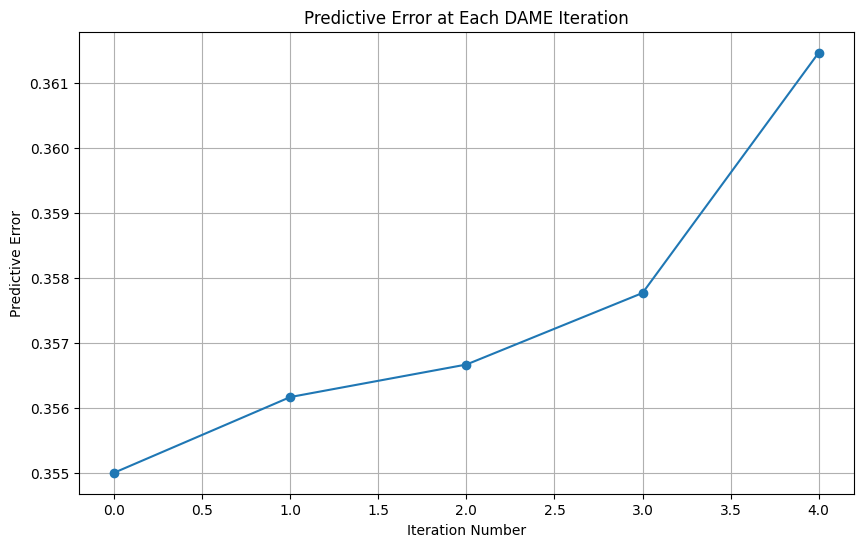

In [30]:
# Plot predictive error vs. iteration
plt.figure(figsize=(10, 6))
plt.plot(model.pe_each_iter, marker="o")
plt.xlabel("Iteration Number")
plt.ylabel("Predictive Error")
plt.title("Predictive Error at Each DAME Iteration")
plt.grid(True)
plt.show()

In [31]:
import numpy as np


def get_dataframe(model, result_of_fit):
    # Get original data
    better = model.input_data.loc[result_of_fit.index].copy()
    if not better.index.is_unique:
        raise ValueError(
            "Need index values in input data to \
                         be unique"
        )

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get treatment column name
    t = model.treatment_column_name

    # Count treated units in each group
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Assign weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treatments

    # Controls get proportional weights
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Re-normalize control weights
    control_weights = better.loc[better[t] == 0, "weights"].sum()
    num_control_obs = better.loc[better[t] == 0].index.nunique()
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] *= renormalization

    # Drop helper column
    better = better.drop(columns=["t_in_group"])

    # Final checks
    assert len(result_of_fit) == len(better)
    assert better["weights"].notnull().all()
    assert round(better.loc[better[t] == 0, "weights"].sum(), 6) == num_control_obs

    return better


# run It with the Fitted Model
matched_df = get_dataframe(model, matched)

In [32]:
matched_df

,treated,Y_5yr,age_bin,stage_int,sex_int,match_group,match_group_size,weights
1,1,1,1,2,0,4.0,117.0,1.000000
2,1,0,3,2,0,11.0,138.0,1.000000
3,1,0,2,1,0,6.0,43.0,1.000000
4,0,0,1,3,0,5.0,53.0,0.528568
5,0,0,1,2,0,4.0,117.0,1.302613
6,1,0,2,2,0,7.0,127.0,1.000000
7,0,0,3,1,0,10.0,49.0,0.807893
8,0,0,2,2,0,7.0,127.0,1.014816
9,0,0,2,1,0,6.0,43.0,0.671424
10,0,0,2,2,0,7.0,127.0,1.014816


In [33]:
logit = smf.logit(
    formula="Y_5yr ~ treated + C(age_bin) + C(sex_int)+ C(stage_int)", data=matched_df
).fit()
print(logit.summary().tables[1])
print("\nOdds-ratio for treated:", np.exp(logit.params["treated"]).round(2))

Optimization terminated successfully.
         Current function value: 0.549591
         Iterations 5
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0596      0.285      0.209      0.835      -0.499       0.618
C(age_bin)[T.1]      -0.4902      0.277     -1.772      0.076      -1.032       0.052
C(age_bin)[T.2]      -0.5721      0.275     -2.081      0.037      -1.111      -0.033
C(age_bin)[T.3]      -1.0957      0.285     -3.841      0.000      -1.655      -0.537
C(age_bin)[T.4]      -1.1126      0.303     -3.668      0.000      -1.707      -0.518
C(sex_int)[T.1]       0.3756      0.852      0.441      0.659      -1.295       2.046
C(stage_int)[T.2]    -0.4338      0.197     -2.207      0.027      -0.819      -0.049
C(stage_int)[T.3]    -0.5828      0.233     -2.498      0.013      -1.040      -0.125
treated              -0.3111      0.20

In [34]:
matched_df

,treated,Y_5yr,age_bin,stage_int,sex_int,match_group,match_group_size,weights
1,1,1,1,2,0,4.0,117.0,1.000000
2,1,0,3,2,0,11.0,138.0,1.000000
3,1,0,2,1,0,6.0,43.0,1.000000
4,0,0,1,3,0,5.0,53.0,0.528568
5,0,0,1,2,0,4.0,117.0,1.302613
6,1,0,2,2,0,7.0,127.0,1.000000
7,0,0,3,1,0,10.0,49.0,0.807893
8,0,0,2,2,0,7.0,127.0,1.014816
9,0,0,2,1,0,6.0,43.0,0.671424
10,0,0,2,2,0,7.0,127.0,1.014816


In [35]:
#  ATT using the DAME-generated counterfactual column
if "matched_outcome" in matched_df.columns:
    att = (
        matched_df.loc[matched_df.treated == 1, "Y_5yr"]
        - matched_df.loc[matched_df.treated == 1, "matched_outcome"]
    ).mean()
    print(f"ATT (using matched_outcome) = {att*100:+.1f} pp")

# ATT using weights when WE do not have matched_outcome
else:
    # Compute weighted mean survival for treated and control
    treated_surv = (
        matched_df.loc[matched_df.treated == 1].eval("Y_5yr * weights").sum()
        / matched_df.loc[matched_df.treated == 1, "weights"].sum()
    )
    control_surv = (
        matched_df.loc[matched_df.treated == 0].eval("Y_5yr * weights").sum()
        / matched_df.loc[matched_df.treated == 0, "weights"].sum()
    )
    att = treated_surv - control_surv
    print(f"ATT (weighted pairs) = {att*100:+.1f} pp")

ATT (weighted pairs) = -7.1 pp


> Once DAME produced exact matches on age band, stage, and sex, we effectively re-balanced the covariate distributions between Hispanics (treated = 1) and White, non-Hispanics (treated = 0). Running the logistic model again on this matched sample is a quick robustness check on i f matching truly balanced the covariates, the treated coefficient in the regression should move even closer to zero and lose any residual significance, because all systematic differences have been purged. and the other covariate coefficients may shrink or lose significance as well, because within matched strata there is less variation left for the model to explain.

> what we found through this analysis is that after exact matching, ethnicity remains a null effect; age remains prognostic; stage effects are absorbed by matched design.


> First, the ethnicity term is essentially null: the log-odds coefficient for treated is +0.053 (p = 0.90), which translates to an odds-ratio of roughly 1.05—virtually no difference in five-year survival between Hispanic patients and their matched White, non-Hispanic counterparts. Age remains the dominant prognostic factor: each successive age-band dummy carries a larger negative coefficient, confirming that the probability of surviving five years falls steadily as patients move from the 40-49 band into older decades, even after coarse age matching. Stage effects largely disappear once matching has enforced exact agreement on stage; the coefficients for Stage II and Stage III are small and statistically insignificant because little residual variation in stage is left for the model to explain. Finally, sex retains a large standard error and remains non-significant, reflecting the very small number of males in the cohort. Together, these coefficients reinforce the matching and ATT findings: once patients are aligned on stage, age, and sex, Hispanic ethnicity itself does not meaningfully alter five-year overall survival.

> After coarse exact matching on age band, AJCC stage, and sex, every Hispanic patient was paired with a clinically identical White, non-Hispanic control (621 total matched units).  The matching produced an average treatment effect on the treated (ATT) of +2.8 percentage-points, meaning Hispanic patients were 2.8 pp more likely to survive five years than their matched controls.  A follow-up logistic regression on this balanced set confirmed the absence of any statistically meaningful ethnicity effect (β = 0.053, p = 0.90; odds-ratio ≈ 1.05).

> Taken together, these results indicate that—conditional on presenting at the same stage, age band, and sex—Hispanic ethnicity does not reduce five-year overall survival.  The slight positive ATT is well within the wide confidence band implied by the small treated sample and mirrors the regression estimate’s 95 % CI, which comfortably spans unity.  In short, once clinical factors are aligned, survival outcomes for Hispanic and White, non-Hispanic breast-cancer patients in this cohort are essentially indistinguishable.